# Predicting Star Ratings of Edinburgh Airbnbs through Review Texts Analysis

# Notebook 4: Modelling

In this notebook, we will further process our Airbnb reviews using natural language processing (NLP) and machine learning techniques. We will define a customized tokenizer to remove any irrelevant contents from the text and separate the review texts into individual words. After that, we will utilize different machine learning models and attempt to find the best-performing models by tuning hyperparameters using GridSearch. Finally, we will use evaluation metrics to assess our results.

***

# Table of Contents

***

#### Import Libraries

In [29]:
# Main Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# NLP Libraries
import nltk
import re
import string
import html
import contractions
import langid
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from langid.langid import LanguageIdentifier

# Download english stopwords from nltk
nltk.download('stopwords')

# Feature Extraction Libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Dummy Classifer 
from sklearn.dummy import DummyClassifier

# Modelling Libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Evaluation Libraries
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

import joblib

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\12276\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Loading Relevant Data

In [2]:
# Load two types of preprocessed review data
df_collapsed_reviews = joblib.load('data/df_collapsed_reviews_by_listing.pkl')
df_reviews_by_listing= joblib.load('data/df_reviews_by_listing.pkl')

#### Ignore userwarnings

In [3]:
import warnings

# Ignore UserWarning
warnings.filterwarnings('ignore', category=UserWarning)

***

# Customized Text Tokenizer

Our ultimate goal is to use machine learning models to accurately predict guests' sentiment scores, determining whether they will give a rating of over 4.8 or not. To enable the models to comprehend the review texts, we must first separate the documents into individual tokens. This task requires defining various tokenizing requirements to remove irrelevant text components from the data. Therefore, our customized text tokenizer should be able to:
- Lowercase text
- Remove punctuations
- Remove Whitespaces
- Remove HTML white spaces of format <br/>
- Remove emails
- Remove emojis
- Remove English Stop words
- Remove special characters
- Remove numbers
- Remove weblinks
- Expand contractions
- Remove Non-English Text Characters (Mixed with English review that was not detected and filtered in the pre-processing stage)
- Perfome Texts Stemming (Cutting off 's', 'ing' and other endings to reduce words to a basic root form)

In [4]:
def customized_tokenizer(sentence):
    
    # Remove HTML tags and entities
    sentence = html.unescape(sentence)
    sentence = re.sub(r'<[^>]+>', '', sentence)
    
    # Remove HTML white spaces \r<br/> and <br/>
    sentence = re.sub(r'(\r<br/>)|(<br/>)', ' ', sentence)
    
    # Remove punctuations
    sentence = re.sub(r'[^\w\s]', '', sentence)
    
    # Lowercase text
    sentence = sentence.lower()
    
    # Remove whitespaces
    sentence = re.sub(r'\s+', ' ', sentence)
    
    # Remove emails
    sentence = re.sub(r'\S*@\S*\s?', '', sentence)
    
    # Remove emojis
    sentence = sentence.encode('ascii', 'ignore').decode('ascii')
    
    # Remove special characters
    sentence = re.sub(r'[^A-Za-z\s]', '', sentence)
    
    # Remove numbers
    sentence = re.sub(r'[0-9]+', '', sentence)
    
    # Remove weblinks
    sentence = re.sub(r'http\S+', '', sentence)
    
    # Expand contractions
    sentence = contractions.fix(sentence)
    
    # Remove non-English text characters
    if langid.classify(sentence)[0] != 'en':
        sentence = ''
    
    # Remove English stopwords
    eng_stop_words=stopwords.words('english')
    stop_words = set(eng_stop_words)
    tokens = sentence.split()
    sentence = ' '.join([word for word in tokens if word.lower() not in stop_words])
    
    # Perform text stemming
    porter = nltk.stem.PorterStemmer()
    sentence = ' '.join([porter.stem(word) for word in sentence.split()])
    
    # Tokenize cleaned sentence
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(sentence)
    
    return tokens

In [5]:
#eng_stop_words.extend(['could','would','edinburgh'])

#### Save function as a pickle file

In [6]:
joblib.dump(customized_tokenizer, 'data/customized_tokenizer.pkl')

['data/customized_tokenizer.pkl']

***

# Reviews without collapsed

Because we have two options of gathering guests' reviews, we will first use the dataset contains individual reviews by listing for our analysis.

#### Check the data shape

In [7]:
print(f'The dataset contains all reviews listed individually is of dimension {df_reviews_by_listing.shape}')

The dataset contains all reviews listed individually is of dimension (470685, 57)


## Split variables

We need to split the variables into dependent and independent variables before we start fitting the model. The target variable will be the sentiment scores. We will focus on the overall sentiment score and attempt to further analyse the reviews with the other sub-rating transformed sentiment scores.

In [8]:
# Define X and y for the future model
X = df_reviews_by_listing.drop(['listing_id',
                               'Overall_sentiment',
                               'accuracy_sentiment',
                               'cleanliness_sentiment',
                               'checkin_sentiment',
                               'communication_sentiment',
                               'location_sentiment',
                               'value_sentiment'], axis=1)
y = df_reviews_by_listing['Overall_sentiment']

In [9]:
print(f"X Shape: {X.shape}")
print(f"y Shape: {y.shape}")

X Shape: (470685, 49)
y Shape: (470685,)


In [10]:
X.head(1).T

,0
host_response_rate,100.0
host_acceptance_rate,92.0
host_is_superhost,0
latitude,55.95759
longitude,-3.18805
accommodates,2
bathroom_num,1.0
beds,1.0
minimum_nights,3
maximum_nights,30


In [11]:
y.unique()

array([1, 0], dtype=int64)

The dependent variable stored as **X** contains all cleaned listing related numerical data as well as a column that contains the guest review data.

The independent variable stored as **y** contains the **Overall sentiment score** that was transformed from the listing's average overall rating score:
- 1 was denoted by Overall rating score > 4.8
- 0 was denoted by Overall rating score < 4.8

***

## Train Test Split

The modelling process starts by splitting our dataset into training and testing sets. This procedure is fundamental for the effective evaluation of our model performance.

The training data is implemented upon which our model is built and refined, and the testing data provides the benchmark for assessing the model's predictive performance on unseen data. This ensures us to mitigate the risk of **overfitting**, as our model will not just memorize the data pattern but rather learns to generalize on new, unseen data.

Additionally, it is important that this splitting process must precede any data transformation steps including vectorization and scaling to prevent potential **data leakage**.

In [12]:
# Split test data as 30% of all data, determine random state to make sure every split is the same
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

# Reset shuffled training and testing data
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

***

# Baseline Model

In the EDA notebook, we analyzed the distribution of overall sentiments in the listing data and showed that the scores are balanced (**1: 58%, 0: 42%**). Now that we've merged all reviews with their corresponding listings and attached sentiment scores, it's important to recheck the distribution to ensure that the sentiment scores remain balanced after the data merging process.

#### Current target variable distribution

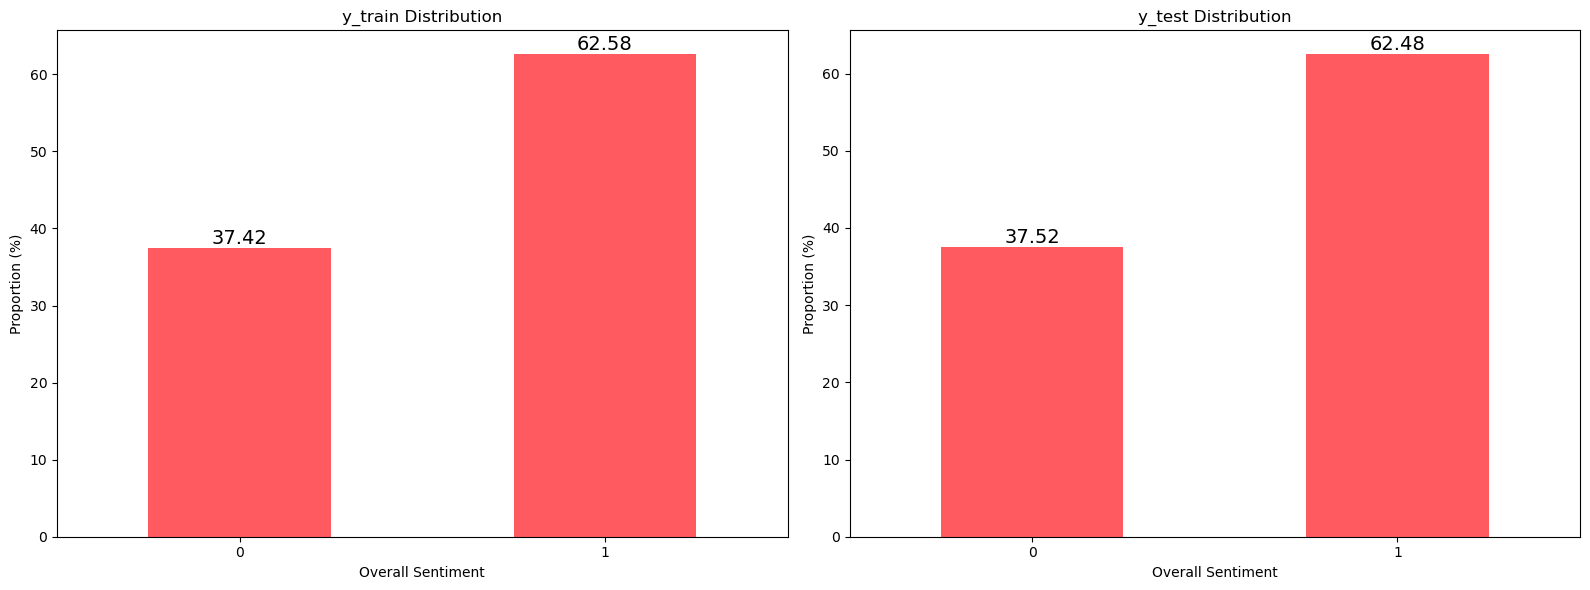

In [13]:
# Create distribution results for both train and test target variable
y_train_distribution=round(y_train.value_counts(normalize=True).sort_index()*100, 2)
y_test_distribution=round(y_test.value_counts(normalize=True).sort_index()*100, 2)


# Plotting the Current Target Variable Distribution
plt.subplots(1, 2, figsize=(16,6))  

# Subplot for y_train
plt.subplot(1, 2, 1)  
y_train_d = y_train_distribution.plot.bar(color='#FF5A5F')
plt.title('y_train Distribution')
plt.xlabel('Overall Sentiment')
plt.ylabel('Proportion (%)')
plt.bar_label(y_train_d.containers[0], size=14)
plt.xticks(rotation = 360)

# Subplot for y_test
plt.subplot(1, 2, 2)  
y_test_d = y_test_distribution.plot.bar(color='#FF5A5F')
plt.title('y_test Distribution')
plt.xlabel('Overall Sentiment')
plt.ylabel('Proportion (%)')
plt.bar_label(y_test_d.containers[0], size=14)
plt.xticks(rotation = 360)

plt.tight_layout()  
plt.show()

The current sentiment score distribution is not as balanced as before, thus we will utilize the **F1** score instead of the **accuracy** score during future evaluation processes.

Furthermore, as we are developing the best performed models for predicting the class of guest sentiments, it is crucial to establish a baseline model for comparison. We will utilise a **Dummy Classifier** model, which makes predictions without accessing dataset features, essentially performing random guessing. By establishing this baseline, we can decide that any model performing worse than the baseline model will not proceed to further analysis.

In [14]:
# Vectorize data
tfidf_vec = TfidfVectorizer(max_features = 1000, 
                            min_df=5, 
                            max_df = 0.95,
                            tokenizer=customized_tokenizer)

# Fit and transform on the vectorizer to training data
X_train_tfidf_d = tfidf_vec.fit_transform(X_train['comments']).toarray()

# Transform on both training data and testing data
X_test_tfidf_d = tfidf_vec.transform(X_test['comments']).toarray()

# Merge the resulting arrays with the original numeric features
X_train_tfidf_d_transformed = pd.concat([X_train.drop(['comments'], axis=1),
                                         pd.DataFrame(X_train_tfidf_d, columns=[i for i in tfidf_vec.get_feature_names_out()])], axis=1)

X_test_tfidf_d_transformed = pd.concat([X_test.drop(['comments'], axis=1), 
                                        pd.DataFrame(X_test_tfidf_d, columns=[i for i in tfidf_vec.get_feature_names_out()])], axis = 1)

# Print shape of the vectorized training feature data
print(f'X_train_transfomed_dummy : {X_train_tfidf_d_transformed.shape}')

X_train_transfomed_dummy : (329479, 1048)


In [20]:
# # Dummy Classifier - Baseline Model
# Instantiate Dummy Classifier
dummy_classifier = DummyClassifier()

# Fit the Dummy Classifier on Training data
dummy_classifier.fit(X_train_tfidf_d_transformed, y_train)

# Predict the fitted model on Testing Data
y_predict_d = dummy_classifier.predict(X_test_tfidf_d_transformed)

# Print F1 score
print(f'The F1 Score (%) for the Baseline Model is: {round(f1_score(y_test, y_predict_d)*100, 2)}')

The F1 Score (%) for the Baseline Model is: 76.91


#### Classification report

In [24]:
print_line = "\n=======================================================\n"
print("Classification Report: Dummy Classifier", print_line)
class_report_baseline = classification_report(y_test, y_predict_d)
print(class_report_baseline)
print(print_line)

Classification Report: Dummy Classifier 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     52984
           1       0.62      1.00      0.77     88222

    accuracy                           0.62    141206
   macro avg       0.31      0.50      0.38    141206
weighted avg       0.39      0.62      0.48    141206





#### Confusion Matrix

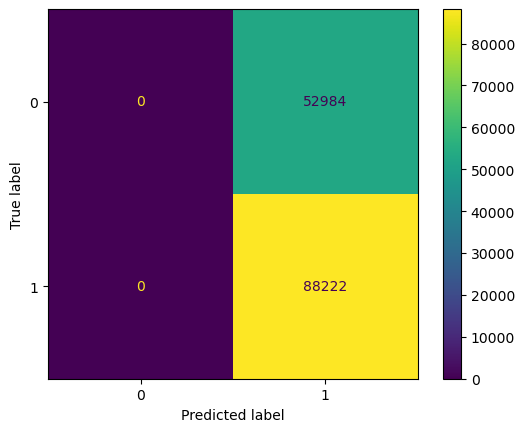

In [37]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(dummy_classifier, X_test_tfidf_d_transformed, y_test)

# Helper Function